In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import time
from omegaconf import OmegaConf
import h5py
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
import diffusion_pde as dpde
from pathlib import Path
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [2]:
data_dir = Path().cwd().parent / "data" / "heat_logt.hdf5"
conf_dir = Path().cwd().parent / "conf"
assert data_dir.exists(), f"Data directory {data_dir} does not exist."
assert conf_dir.exists(), f"Config directory {conf_dir} does not exist."
print("Data directory:", data_dir)
print("Config directory:", conf_dir)

Data directory: /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5
Config directory: /home/s204790/dynamical-pde-diffusion/conf


In [3]:
conf = OmegaConf.load(conf_dir / "config.yaml")
print(OmegaConf.to_yaml(conf))

defaults:
- dataset: heat_eq
- model: unet
wandb:
  entity: philiphohwy-danmarks-tekniske-universitet-dtu
  project: dynamical-pde-diffusion
  dir: ${oc.env:REPO_ROOT,${hydra:runtime.cwd}}/logs
  name: None
hydra:
  run:
    dir: ${oc.env:REPO_ROOT,${hydra:runtime.cwd}}/logs/hydra/${now:%Y-%m-%d_%H-%M-%S}
  sweep:
    dir: ${oc.env:REPO_ROOT,${hydra:runtime.cwd}}/logs/hydra_multirun
    subdir: ${hydra.job.num}
model_save_path: ${oc.env:REPO_ROOT,${hydra:runtime.cwd}}/pretrained_models



In [4]:
with h5py.File(data_dir, "r") as f:
    U = f["train/U"][:]  # (N, 1, S, S, steps+1)
    A = f["train/A"][:]  # (N, 1, S, S)
    labels = f["train/labels"][:]  # (N,)
    t_steps = f["t_steps"][:]  # (steps+1,)
    attrs = dict(f.attrs)
print(attrs)
assert np.allclose(U[..., 0], A)

{'Lx': np.float64(1.0), 'Ly': np.float64(1.0), 'S': np.int64(64), 'T': np.float64(0.5), 'alpha_logrange': array([-2.,  0.]), 'description': '2D heat equation with linear Dirichlet BCs, data generated with sine-pseudospectral method with lifting. Time steps in log-scale.', 'dx': np.float64(0.015873015873015872), 'name': 'heat_logt', 'num_test': np.int64(200), 'num_train': np.int64(800), 'steps': np.int64(64)}


In [5]:
print(t_steps)

[0.00000000e+00 1.42342687e-05 3.04946807e-05 4.90696475e-05
 7.02886246e-05 9.45279680e-05 1.22217607e-04 1.53848654e-04
 1.89982165e-04 2.31258993e-04 2.78411317e-04 3.32275376e-04
 3.93806637e-04 4.64096403e-04 5.44391340e-04 6.36115728e-04
 7.40896445e-04 8.60591885e-04 9.97325173e-04 1.15352147e-03
 1.33195100e-03 1.53577875e-03 1.76861999e-03 2.03460408e-03
 2.33844947e-03 2.68554501e-03 3.08204698e-03 3.53498803e-03
 4.05240245e-03 4.64346632e-03 5.31866401e-03 6.08997140e-03
 6.97106728e-03 7.97758158e-03 9.12736636e-03 1.04408143e-02
 1.19412225e-02 1.36552025e-02 1.56131554e-02 1.78498086e-02
 2.04048324e-02 2.33235452e-02 2.66577154e-02 3.04664802e-02
 3.48173976e-02 3.97876352e-02 4.54653464e-02 5.19512407e-02
 5.93603514e-02 6.78240955e-02 7.74925947e-02 8.85373354e-02
 1.01154208e-01 1.15567006e-01 1.32031366e-01 1.50839299e-01
 1.72324404e-01 1.96867749e-01 2.24904671e-01 2.56932437e-01
 2.93519109e-01 3.35313648e-01 3.83057356e-01 4.37597007e-01
 4.99899954e-01]


U min: -0.5936176776885986, max: 0.8791067004203796


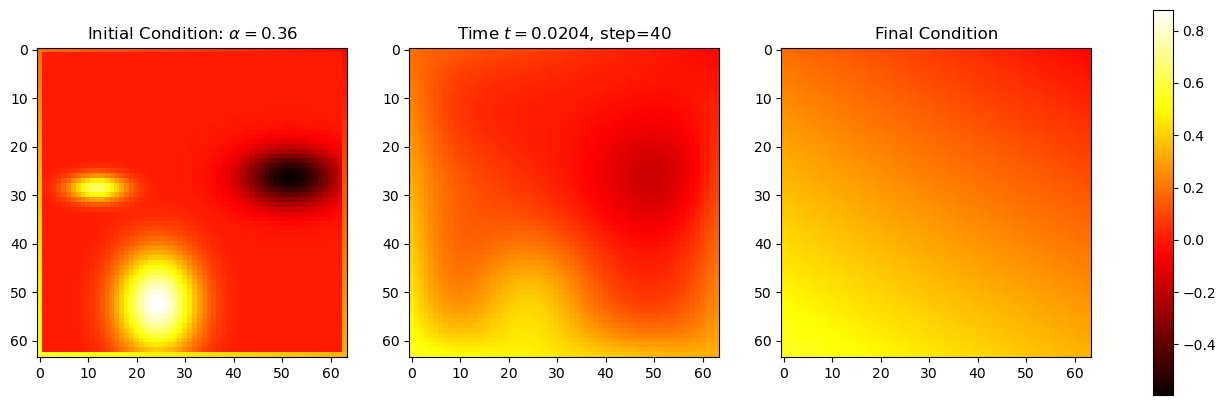

In [6]:
idx = 1
t_idx = 40  # which time step to visualize
vmin, vmax = U[idx].min(), U[idx].max()
print(f"U min: {vmin}, max: {vmax}")

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(U[idx, 0, :, :, 0], cmap='hot', vmin=vmin, vmax=vmax)
axs[0].set_title(f'Initial Condition: $\\alpha={labels[idx, 0]:.2f}$')
axs[1].imshow(U[idx, 0, :, :, t_idx], cmap='hot', vmin=vmin, vmax=vmax)
axs[1].set_title(f'Time $t={t_steps[t_idx]:.4f}$, step={t_idx}')
axs[2].imshow(U[idx, 0, :, :, -1], cmap='hot', vmin=vmin, vmax=vmax)
axs[2].set_title('Final Condition')
fig.colorbar(axs[1].images[0], ax=axs, orientation='vertical', fraction=.1)
plt.show()

In [7]:
diff = U[..., 1:] - U[..., :-1]
diff = np.permute_dims(diff, (0, 4, 1, 2, 3)).squeeze()  # shape (N, T-1, h, w)
norm_diff = np.linalg.norm(diff.reshape(diff.shape[0], diff.shape[1], -1), axis=-1)  # shape (N, T-1)
mean_norm_diff = norm_diff.mean(axis=0)  # shape (T-1,)
print(diff.shape)
print(norm_diff.shape)
print(mean_norm_diff.shape)

(800, 64, 64, 64)
(800, 64)
(64,)


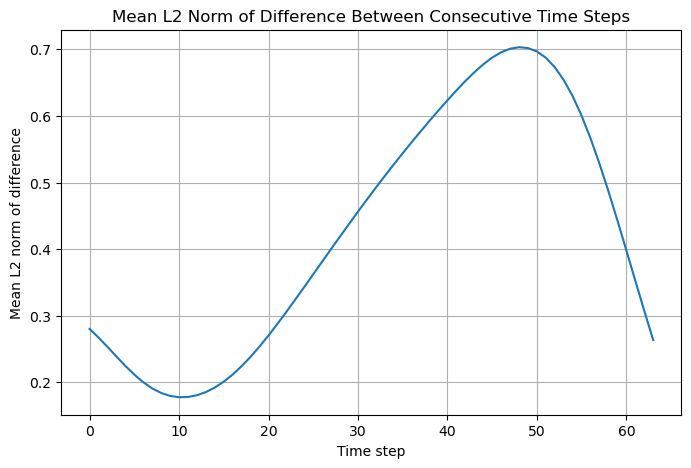

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(mean_norm_diff)
#plt.plot(norm_diff[:10].T)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Time step')
plt.ylabel('Mean L2 norm of difference')
plt.title('Mean L2 Norm of Difference Between Consecutive Time Steps')
plt.grid(True)
plt.show()

In [9]:
data_shape = A.shape[-2:]
ch_a = A.shape[1]
ch_u = U.shape[1]
N = A.shape[0]
num_tsteps = t_steps.shape[0]
label_dim = labels.shape[1]

print(f"Data shape: {data_shape}, ch_a: {ch_a}, ch_u: {ch_u}, N: {N}, num_tsteps: {num_tsteps}, label_dim: {label_dim}")

Data shape: (64, 64), ch_a: 1, ch_u: 1, N: 800, num_tsteps: 65, label_dim: 1


In [10]:
batch_size = 16

dataloader = dpde.datasets.get_dataloader(
    datapath=str(data_dir),
    batch_size=batch_size,
    shuffle=True,
)

In [11]:
X, label = next(iter(dataloader))
print(f"batches in train loader: {len(dataloader)}, samples = {len(dataloader.dataset)}")
print("X shape:", X.shape, f"Expected shape: ({batch_size}, {ch_a + ch_u}, {data_shape[0]}, {data_shape[1]})")  # Expected shape: (2, ch0 + ch1, h, w)
print("Label shape:", label.shape, f"Expected shape: ({batch_size}, {label_dim + 1})\n")

batches in train loader: 50, samples = 800
X shape: torch.Size([16, 2, 64, 64]) Expected shape: (16, 2, 64, 64)
Label shape: torch.Size([16, 2]) Expected shape: (16, 2)



In [12]:
chs = [ch_a + ch_u, 32, 64, 128, 256]

unet = dpde.models.Unet(chs, label_ch=label_dim + 1)
edm_model = dpde.models.EDMWrapper(unet)
loss = dpde.models.EDMLoss()

In [13]:
sigma = torch.ones(X.shape[0]) * 0.01

t1 = time.perf_counter()
for i in range(100):
    X1, dXdt1 =dpde.sampling.X_and_dXdt(edm_model, X, sigma, label)
t2 = time.perf_counter()
print(f"Time for 100 runs of X_and_dXdt: {t2 - t1:.4f} seconds")

t1 = time.perf_counter()
for i in range(100):
    X2, dXdt2 =dpde.sampling.X_and_dXdt_fd(edm_model, X, sigma, label, eps=1e-2)
t2 = time.perf_counter()
print(f"Time for 100 runs of X_and_dXdt_fd: {t2 - t1:.4f} seconds")

Time for 100 runs of X_and_dXdt: 80.0274 seconds
Time for 100 runs of X_and_dXdt_fd: 78.2708 seconds


In [21]:
assert torch.allclose(X1, X2, atol=1e-5), "X1 and X2 are not close!"
assert torch.allclose(dXdt1, dXdt2, atol=1e-3), "dXdt1 and dXdt2 are not close!"
print("X1 and X2 are close!")

X1 and X2 are close!


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
edm_model = edm_model.to(device)

device: cuda


In [13]:
wandb_kwargs = {
    "entity": "philiphohwy-danmarks-tekniske-universitet-dtu",
    "project": "dynamical-pde-diffusion",
    "name": "test-run2",
    "tags": ["testing", "unet", "edm"],
    "notes": "This is a test run to check if the training loop works.",
}

In [15]:
"""
dpde.training.train(
    model=edm_model,
    dataloader=loader1,
    loss_fn=loss,
    device=device,
    epochs=5,
    lr=1e-4,
    weight_decay=0.0,
    wandb_kwargs=wandb_kwargs
)
"""

'\ndpde.training.train(\n    model=edm_model,\n    dataloader=loader1,\n    loss_fn=loss,\n    device=device,\n    epochs=5,\n    lr=1e-4,\n    weight_decay=0.0,\n    wandb_kwargs=wandb_kwargs\n)\n'